# Initialize

## Import libraries

In [97]:
import sys
import time
import os
from os import path
from os.path import join
from importlib import reload
import logging
logging.basicConfig(level=logging.INFO)
from tqdm import tqdm

import numpy as np
import h5py

import ipywidgets
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import scipy as scp
import scipy.constants as con
from scipy import stats
from scipy.ndimage import gaussian_filter

from PIL import Image, ImageOps
from skimage.draw import (line, polygon, disk,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve, ellipsoid, rectangle)

# Self-written libraries
sys.path.append(join(os.getcwd(), "library"))
import mask_lib
import fthcore as fth
import helper_functions as helper
import interactive
from interactive import cimshow
import reconstruct_rb as rec

In [98]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    # Self-written library
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR

    print("GPU available")
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU available


In [99]:
# Is there a GPU?
# Cupy
try:
    import cupy as cp
    import cupyx as cpx
    import CCI_core_cupy as cci
    import Phase_Retrieval as PhR
    GPU = True
except:
    import CCI_core as cci
    GPU = False

In [100]:
# interactive plotting
import ipywidgets

%matplotlib widget

# Auto formatting of cells
#%load_ext jupyter_black
plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

## Experiment specific functions

In [101]:
# Setup phase and propagation for cdi once
phase_cdi = 0
prop_dist_cdi = 0
dx = 0
dy = 0


def phase_retrieval(
    pos, mask_pixel, supportmask, vmin = 0, Startimage=None, Startgamma=None
):
    # Prepare Input holograms
    pos2 = pos.copy()

    mi, _ = np.percentile(pos2[pos2 != 0], [vmin, 99.9])
    pos2 = pos2 - mi

    pos2[pos2 < 0] = 0
    pos2 = pos2.astype(complex)

    bsmask_p = mask_pixel.copy()
    bsmask_p[pos2 <= 0] = 1

    # Setup start image and startgamma
    if Startimage is None:
        Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask)))
    else:
        Startimage = Startimage.copy()
    if Startgamma is None:
        Startgamma = np.ones(pos.shape) * 1e-6 * 2
        Startgamma[pos.shape[0] // 2, pos.shape[1] // 2] = 0.7
    else:
        Startgamma = Startgamma.copy()

    # Settings for phase retrieval reconstructions
    partial_coherence = False

    # Setup
    retrieved_p = np.zeros(pos2.shape, np.cdouble)
    retrieved_n = np.zeros(pos2.shape, np.cdouble)

    # Algorithms and Inital guess
    plt.rcParams["figure.dpi"] = 100
    print("CDI - larger mask")

    algorithm_list = ["HIO", "ER", "HIO", "ER", "HIO", "ER", "HIO", "ER", "HIO", "ER", "HIO", "ER", "HIO", "ER" ]
    Nit_list = [300, 50, 300, 50, 300, 50, 300,50, 300, 50, 300, 50, 300,50 ]  # iterations for algorithm_list

    x = (np.sqrt(np.maximum(pos2, np.zeros(pos2.shape)))[mask_pixel == 0]).flatten()
    y = ((np.abs(Startimage))[mask_pixel == 0]).flatten()
    res = stats.linregress(x, y)
    Startimage -= res.intercept
    Startimage /= res.slope

    average_img = 30
    real_object = False  # always set to False

    if partial_coherence:
        RL_freq = 20
        RL_it = 50

        algorithm_list_pc = ["mine", "ER", "mine", "ER", "mine", "ER", "mine", "ER", "mine", "ER", "mine", "ER", "mine", "ER"]
        Nit_list_pc = [700, 50, 300, 50, 300, 50, 300, 50, 300, 50, 300, 50, 300, 50]

    # Execute Phase retrieval
    start_time = time.time()
    for i in range(len(Nit_list)):
        print("############ -   CDI", i)

        # Positive helicity - beta_mode="arctan"
        retrieved_p, Error_diff_p, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[i],
            beta_zero=0.5,
            Nit=Nit_list[i],
            beta_mode="arctan",
            plot_every=349,
            Phase=Startimage,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

        Startimage = retrieved_p.copy()

        # Partial coherence phase retrieval
        if partial_coherence:
            # CDI_PC
            print("############   -   CDI_pc")
            pos3 = (np.abs(retrieved_p) ** 2) * bsmask_p + np.maximum(
                pos2, np.zeros(pos2.shape)
            ) * (1 - bsmask_p)

            # retrieve pos image
            (
                retrieved_p_pc,
                Error_diff_p_pc,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list_pc[3 * i],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i],
                beta_mode="arctan",
                gamma=Startgamma,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=349,
                Phase=Startimage,
                seed=False,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            (
                retrieved_p_pc,
                Error_diff_p_pc2,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list[i ],
                beta_zero=0.5,
                Nit=Nit_list_pc[ i ],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

            Startimage = retrieved_p_pc.copy()
            Startgamma = gamma_p.copy()

    print("Phase Retrieval Done!")

    return (
        retrieved_p,
        #retrieved_p_pc,
        bsmask_p,
        #gamma_p,
    )

In [102]:
# Setup phase and propagation for cdi once
phase_cdi = 0
prop_dist_cdi = 0
dx = 0
dy = 0


def phase_retrieval(
    pos, mask_pixel, supportmask, vmin = 0, Startimage=None, Startgamma=None
):
    # Prepare Input holograms
    pos2 = pos.copy()

    mi, _ = np.percentile(pos2[pos2 != 0], [vmin, 99.9])
    pos2 = pos2 - mi

    pos2[pos2 < 0] = 0
    pos2 = pos2.astype(complex)

    bsmask_p = mask_pixel.copy()
    bsmask_p[pos2 <= 0] = 1

    # Setup start image and startgamma
    if Startimage is None:
        Startimage = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(supportmask)))
    else:
        Startimage = Startimage.copy()
    if Startgamma is None:
        Startgamma = np.ones(pos.shape) * 1e-6 * 2
        Startgamma[pos.shape[0] // 2, pos.shape[1] // 2] = 0.7
    else:
        Startgamma = Startgamma.copy()

    # Settings for phase retrieval reconstructions
    partial_coherence = True

    # Setup
    retrieved_p = np.zeros(pos2.shape, np.cdouble)
    retrieved_n = np.zeros(pos2.shape, np.cdouble)

    # Algorithms and Inital guess
    plt.rcParams["figure.dpi"] = 100
    print("CDI - larger mask")

    algorithm_list = ["mine", "ER", "ER"]
    Nit_list = [700, 50, 50]  # iterations for algorithm_list

    x = (np.sqrt(np.maximum(pos2, np.zeros(pos2.shape)))[mask_pixel == 0]).flatten()
    y = ((np.abs(Startimage))[mask_pixel == 0]).flatten()
    res = stats.linregress(x, y)
    Startimage -= res.intercept
    Startimage /= res.slope

    average_img = 30
    real_object = False  # always set to False

    if partial_coherence:
        RL_freq = 20
        RL_it = 50

        algorithm_list_pc = ["mine", "ER", "ER"]
        Nit_list_pc = [1000, 200, 200]

    # Execute Phase retrieval
    start_time = time.time()
    for i in range(len(Nit_list) // 3):
        print("############ -   CDI")

        # Positive helicity - beta_mode="arctan"
        retrieved_p, Error_diff_p, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i],
            beta_zero=0.5,
            Nit=Nit_list[3 * i],
            beta_mode="arctan",
            plot_every=349,
            Phase=Startimage,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )

        # Positive helicity - beta_mode="const"
        retrieved_p, Error_diff_p2, Error_supp = PhR.PhaseRtrv_GPU(
            diffract=np.sqrt(np.maximum(pos2, np.zeros(pos2.shape))),
            mask=supportmask,
            mode=algorithm_list[3 * i + 1],
            beta_zero=0.5,
            Nit=Nit_list[3 * i + 1],
            beta_mode="const",
            plot_every=24,
            Phase=retrieved_p,
            seed=False,
            real_object=real_object,
            bsmask=bsmask_p,
            average_img=average_img,
            Fourier_last=True,
        )


        print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

        Startimage = retrieved_p.copy()

        # Partial coherence phase retrieval
        if partial_coherence:
            # CDI_PC
            print("############   -   CDI_pc")
            pos3 = (np.abs(retrieved_p) ** 2) * bsmask_p + np.maximum(
                pos2, np.zeros(pos2.shape)
            ) * (1 - bsmask_p)

            # retrieve pos image
            (
                retrieved_p_pc,
                Error_diff_p_pc,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list_pc[3 * i],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i],
                beta_mode="arctan",
                gamma=Startgamma,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=349,
                Phase=Startimage,
                seed=False,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            (
                retrieved_p_pc,
                Error_diff_p_pc2,
                Error_supp,
                gamma_p,
            ) = PhR.PhaseRtrv_with_RL(
                diffract=np.sqrt(pos3),
                mask=supportmask,
                mode=algorithm_list[3 * i + 1],
                beta_zero=0.5,
                Nit=Nit_list_pc[3 * i + 1],
                beta_mode="const",
                gamma=gamma_p,
                RL_freq=RL_freq,
                RL_it=RL_it,
                plot_every=24,
                Phase=retrieved_p_pc,
                real_object=False,
                bsmask=np.zeros(bsmask_p.shape),
                average_img=average_img,
                Fourier_last=True,
            )

            print("--- %s seconds ---" % np.round((time.time() - start_time), 2))

            Startimage = retrieved_p_pc.copy()
            Startgamma = gamma_p.copy()

    print("Phase Retrieval Done!")

    return (
        retrieved_p,
        retrieved_p_pc,
        bsmask_p,
        gamma_p,
    )

In [103]:
def gaussian_2d(shape, mean_x, mean_y, sigma_x, sigma_y, amp, normalize = True):
    """
    Erzeugt ein 2D-Gaussian-Verteilungsarray.

    Parameters:
    shape (tuple): Größe des Arrays (MxN)
    mean_x (float): Mittelwert in x-Richtung
    mean_y (float): Mittelwert in y-Richtung
    sigma_x (float): Standardabweichung in x-Richtung
    sigma_y (float): Standardabweichung in y-Richtung
    amp (float): Amplitude to scale gaussian

    Returns:
    np.ndarray: NxN-Array mit der 2D-Gaussian-Verteilung
    """
    x = np.linspace(0, shape[1]-1, shape[1])
    y = np.linspace(0, shape[0]-1, shape[0])
    x, y = np.meshgrid(x, y)

    if normalize is True:
        gaussian =  amp / (2. * np.pi * sigma_x * sigma_y) * np.exp(-((x - mean_x)**2. / (2. * sigma_x**2.) + (y - mean_y)**2. / (2. * sigma_y**2.)))
    else:
        gaussian =  amp * np.exp(-((x - mean_x)**2. / (2. * sigma_x**2.) + (y - mean_y)**2. / (2. * sigma_y**2.)))
    return gaussian

# Create Real-space object and holograms

In [104]:
# Parameter for object generation
nr_objects = 10 #How many object configurations to generate in object aperture?

amplitude_object = 0.1 #Amplitude scaling of gaussian, integration over all pixels is amplitude 
std_object = 5 # Standard deviation of gaussian

radi_ref = 1 #radius of reference apertures
radi_obj = 50 # radius of object aperture

amplitude_drift = 50 #Limit of random deflection

In [105]:
# Create FTH mask for object aperture
mask = np.zeros((1000, 1000))
rr, cc = disk((mask.shape[0]//2, mask.shape[1]//2), radi_obj, shape=mask.shape) #object aperture
mask[rr, cc] = 1 

# Smooth edges
mask = gaussian_filter(mask,2)

# Create mask for reference apertures
mask_ref = np.zeros((1000, 1000))
rr, cc = disk((mask.shape[0]//3, mask.shape[1]//3), radi_ref + 1, shape=mask.shape) # reference 1
mask_ref[rr, cc] = 1
rr, cc = disk((2*mask.shape[0]//3, mask.shape[1]//3), radi_ref + 1, shape=mask.shape) # reference 2
mask_ref[rr, cc] = 1
mask_ref = gaussian_filter(mask_ref,2)
mask_ref = mask_ref/np.max(mask_ref)

# Combine both
mask = mask + mask_ref

holo_mask = np.abs(cci.FFT(mask))**2 # for plotting

# Setup of arrays
holo_avg = np.zeros(mask.shape) 
obj_all  = np.zeros(mask.shape) # Contains all objects for overview plot only

# Put objects in to mask
if nr_objects == 0:
    obj = mask.copy()

    # Calculate hologram
    holo = np.abs(cci.FFT(obj))**2
    holo_avg += holo
    obj_all += obj
    holo_mask = np.abs(cci.FFT(mask))**2
else:
    for i in range(nr_objects):
        # Setup new object which combines mask and particle
        obj = np.zeros(mask.shape)
        
        # Generate random positions for object
        y, x = obj.shape[0]//2+(np.random.random()-0.5)*amplitude_drift, obj.shape[1]//2+(np.random.random()-0.5)*amplitude_drift
        particle = gaussian_2d(obj.shape, y, x, std_object, std_object, amplitude_object,normalize = False)
        obj = mask.copy() + mask*particle
    
        # Calculate hologram and normalize with respect to number of configurations
        holo = np.abs(cci.FFT(obj))**2
        holo_avg += holo/nr_objects
        obj_all += obj/nr_objects

# Reconstruct objects
reco_obj = cci.reconstruct(holo)
reco_avg = cci.reconstruct(holo_avg)

Text(0.5, 1.0, 'Reconstruction of avg holo')

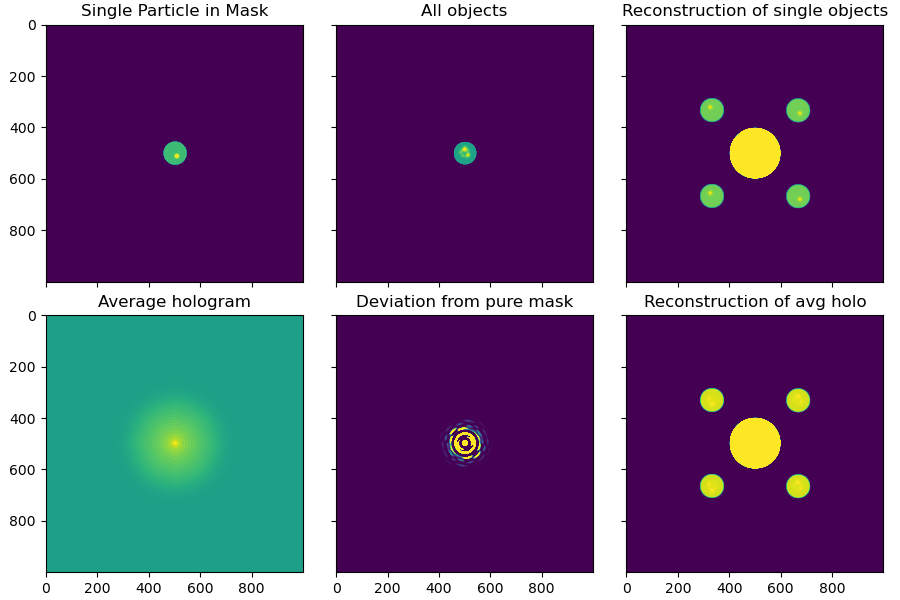

In [106]:
# Plots
fig, ax = plt.subplots(2,3,figsize=(9,6),sharex=True,sharey=True)

# Single Particle
vmin, vmax = np.percentile(obj[obj!=0],[1,99])
ax[0,0].imshow(obj, vmin=1-amplitude_object, vmax=vmax)
ax[0,0].set_title("Single Particle in Mask")

# All particles
vmin, vmax = np.percentile(obj_all[obj_all>=1-amplitude_object],[5,99])
ax[0,1].imshow(obj_all, vmin=vmin, vmax=vmax)
ax[0,1].set_title("All objects")

# Hologram of all particles
vmin, vmax = np.percentile(holo_avg[holo_avg!=0],[1,100])
ax[1,0].imshow(holo_avg+1, norm=LogNorm(vmin=vmin, vmax=vmax))
ax[1,0].set_title("Average hologram")

# Deviation from pure mask
tmp = holo_avg - holo_mask
vmin, vmax = np.percentile(tmp[tmp>=0],[1,99])
ax[1,1].imshow(tmp, vmin=vmin, vmax=vmax)
ax[1,1].set_title("Deviation from pure mask")

# Reconstruction of single objects
tmp = np.abs(reco_obj)
tmp2 = tmp[:,:350]
vmin, vmax = np.percentile(tmp2[tmp2>1],[20,100])
ax[0,2].imshow(tmp, vmin=vmin, vmax=vmax)
ax[0,2].set_title("Reconstruction of single objects")

# Reconstruction of avg holo
tmp = np.abs(reco_avg)
tmp2 = tmp[:,:350]
vmin, vmax = np.percentile(tmp2[tmp2>1],[20,100])
ax[1,2].imshow(tmp, vmin=vmin, vmax=vmax)
ax[1,2].set_title("Reconstruction of avg holo")


# Create masks for all cross correlations

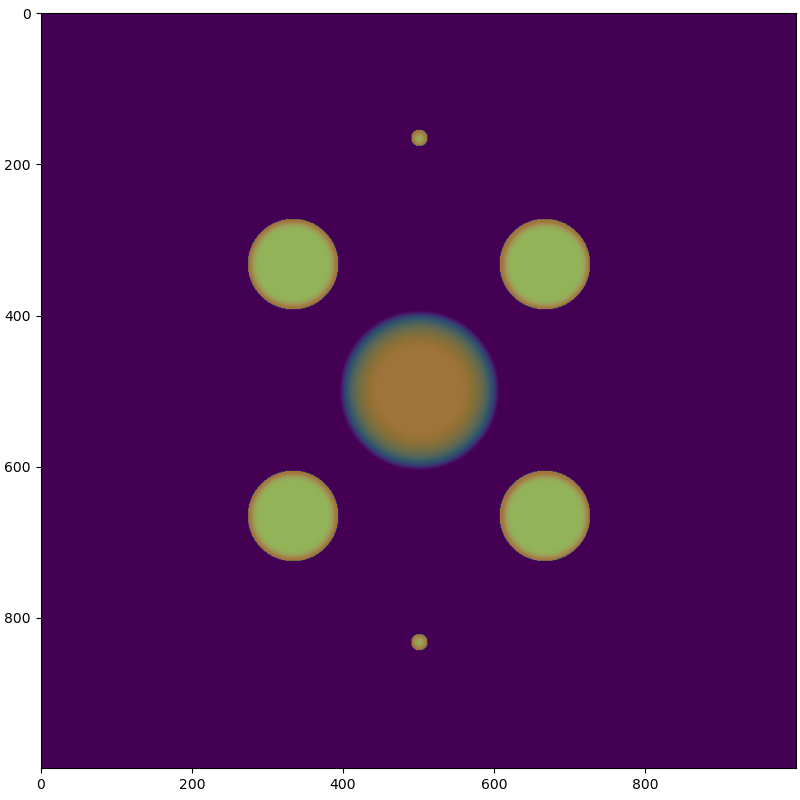

In [107]:
# Just to confirm that all disk coordinates are correct. Sizes are increased by 1px in case of rounding errors
# Reconstructions
reco_coordinates = []
rr, cc = disk((obj.shape[0]//3, obj.shape[1]//3), radi_obj+10, shape=obj.shape)
reco_coordinates.append([rr,cc])
rr, cc = disk((2*obj.shape[0]//3, 2*obj.shape[1]//3), radi_obj+10, shape=obj.shape)
reco_coordinates.append([rr,cc])
rr, cc = disk((obj.shape[0]//3, 2*obj.shape[1]//3), radi_obj+10, shape=obj.shape)
reco_coordinates.append([rr,cc])
rr, cc = disk((2*obj.shape[0]//3, obj.shape[1]//3), radi_obj+10, shape=obj.shape)
reco_coordinates.append([rr,cc])

#reference holes
ref_coordinates = []
rr, cc = disk((2.5*obj.shape[0]//3, obj.shape[1]//2), radi_ref+10, shape=obj.shape)
ref_coordinates.append([rr,cc])
rr, cc = disk((0.5*obj.shape[0]//3, obj.shape[1]//2), radi_ref+10, shape=obj.shape)
ref_coordinates.append([rr,cc])


# Create masks
# Construct mask for all reconstructions
mask_reco = np.zeros((len(reco_coordinates),mask.shape[0],mask.shape[1]))
for i, (rr,cc) in enumerate(reco_coordinates):
    mask_reco[i,rr,cc] = 1

# Construct mask for all references
mask_ref = np.zeros((len(ref_coordinates),mask.shape[0],mask.shape[1]))
for i, (rr, cc) in enumerate(ref_coordinates):
    mask_ref[i,rr,cc] = 1

# Combine to full cross correlation mask
mask_cross = np.sum(mask_reco,axis=0) + np.sum(mask_ref,axis=0)

# Plotting
tmp = np.log10(np.abs(reco_avg)+1)
fig, ax = plt.subplots(figsize=(8,8))
vmin, vmax = np.percentile(tmp[tmp!=0],[5,99])
ax.imshow(mask_cross)
ax.imshow(tmp, vmin=vmin, vmax=vmax,alpha = 0.5)


interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='contrast', layout=Layout(width='500px'),…

interactive(children=(IntSlider(value=0, description='nr', max=3), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'Mask for objects')

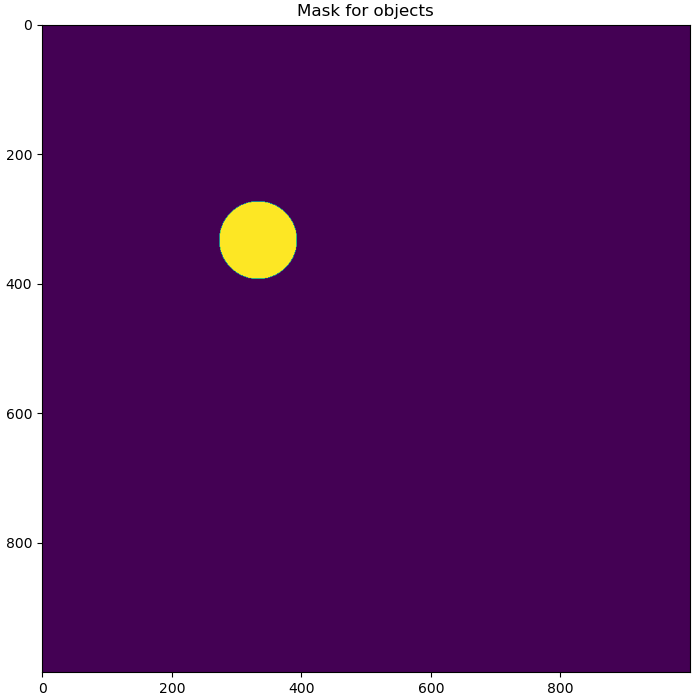

In [108]:
fig, ax = cimshow(mask_reco)
ax.set_title("Mask for objects")

interactive(children=(FloatRangeSlider(value=(0.0, 0.0), description='contrast', layout=Layout(width='500px'),…

interactive(children=(IntSlider(value=0, description='nr', max=1), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'Mask for references')

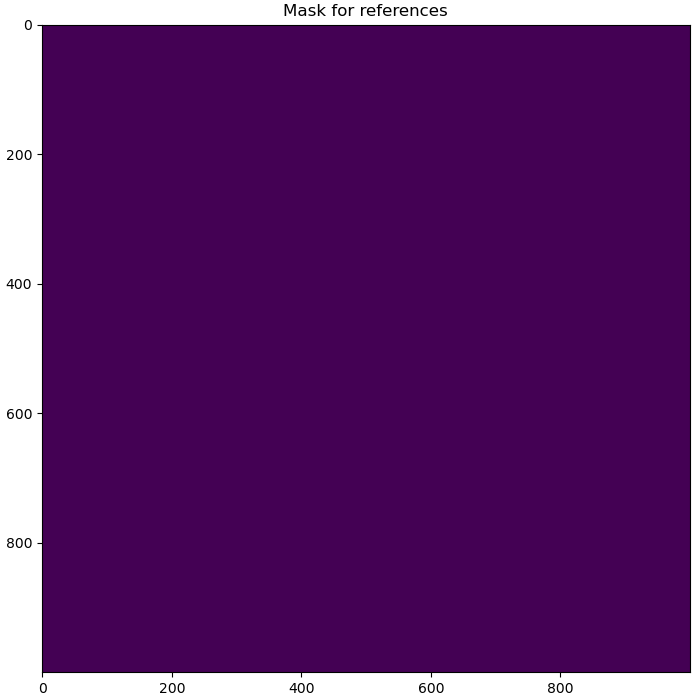

In [109]:
fig, ax = cimshow(mask_ref)
ax.set_title("Mask for references")

# Extract cross_correlation values and calc FFT

In [110]:
# Get cross correlations of reco and ref
cross_reco = reco_avg[np.newaxis,:,:]*mask_reco
cross_ref = reco_avg[np.newaxis,:,:]*mask_ref

# Calc fourier transform of cross correlations
holo_cross_reco = scp.fft.ifftshift(scp.fft.ifft2(scp.fft.fftshift(cross_reco,axes=(1,2)),axes=(1,2)),axes=(1,2))
holo_cross_ref = scp.fft.ifftshift(scp.fft.ifft2(scp.fft.fftshift(cross_ref,axes=(1,2)),axes=(1,2)),axes=(1,2))

interactive(children=(FloatRangeSlider(value=(0.0, 1.488271228187109), description='contrast', layout=Layout(w…

interactive(children=(IntSlider(value=0, description='nr', max=3), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'Selected cross-correlation areas of recos')

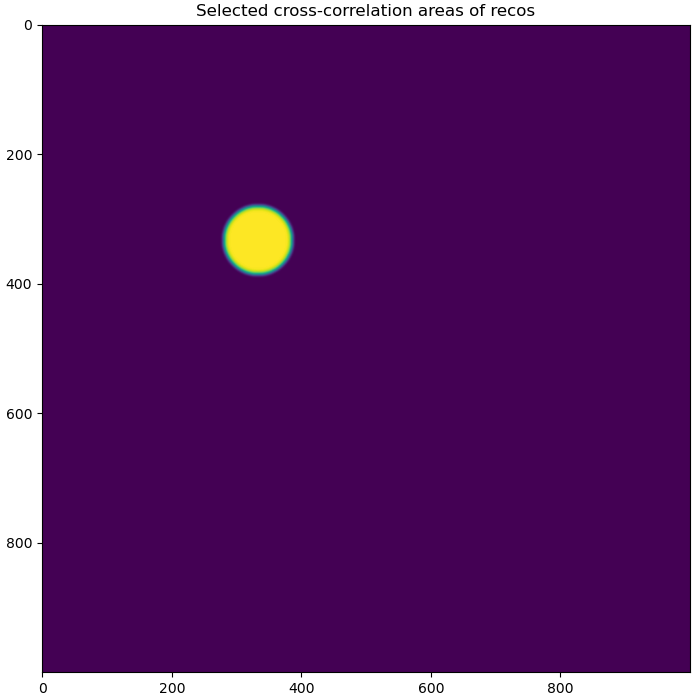

In [111]:
# Series of slideshow plots
fig, ax = cimshow(np.log10(cross_reco+1))
ax.set_title("Selected cross-correlation areas of recos")

interactive(children=(FloatRangeSlider(value=(0.0, 0.0), description='contrast', layout=Layout(width='500px'),…

interactive(children=(IntSlider(value=0, description='nr', max=1), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'Selected cross-correlation areas of references')

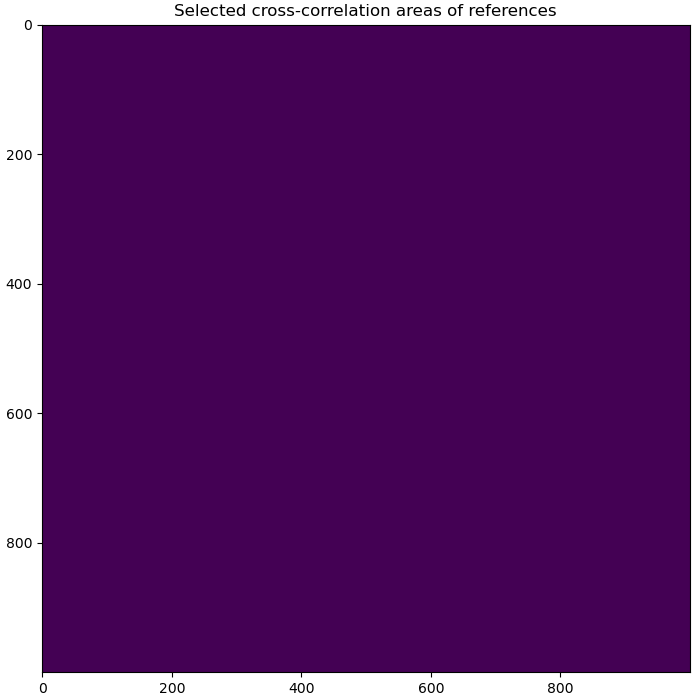

In [112]:
# Series of slideshow plots
fig, ax = cimshow(np.log10(cross_ref+1))
ax.set_title("Selected cross-correlation areas of references")

interactive(children=(FloatRangeSlider(value=(-0.0025462404773926666, 0.002531399006366219), description='cont…

interactive(children=(IntSlider(value=0, description='nr', max=3), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'Selected cross-correlation areas of recos')

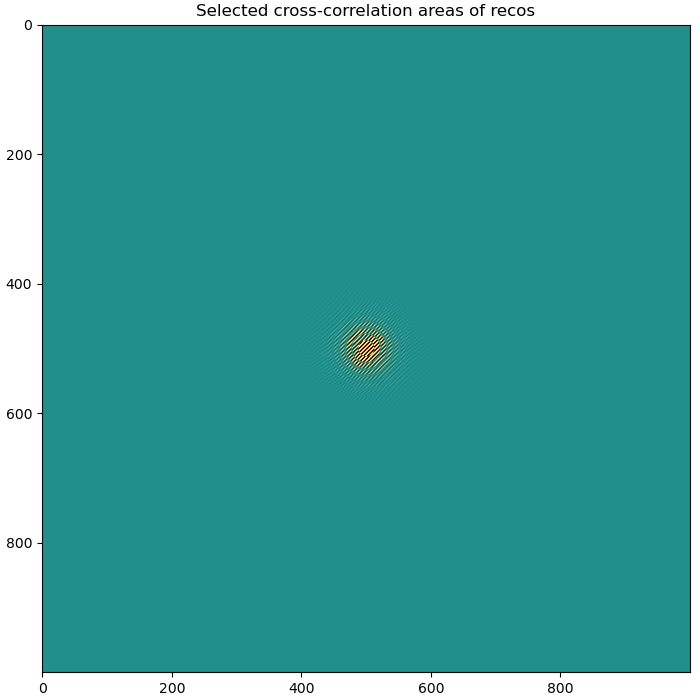

In [113]:
# Series of slideshow plots
fig, ax = cimshow(np.log10(np.imag(holo_cross_reco)+1))
ax.set_title("Selected cross-correlation areas of recos")

# Extract autocorrelation terms

In [114]:
# Auto correlation contribution of object
holo_auto_reco = np.abs(np.sqrt(np.prod(holo_cross_reco,axis=0)/np.prod(holo_cross_ref,axis=0)))

# Auto correlation contribution of references. Care: Cross correlations of reco must be ordered pairwise
# which means that holo_cross_reco[2*i] and holo_cross_reco[2*i+1] are the twin image reconstruction of
# the same reference aperture. Define Masks accordingly!
holo_auto_ref = np.zeros(cross_ref.shape)
for i in range(cross_ref.shape[0]):
    holo_auto_ref[i] = np.abs(holo_cross_reco[2*i]*holo_cross_reco[2*i+1])/holo_auto_reco

interactive(children=(FloatRangeSlider(value=(3.6686020802628614e-11, 0.13672750363273453), description='contr…

Text(0.5, 1.0, 'Auto correlation contribution of object')

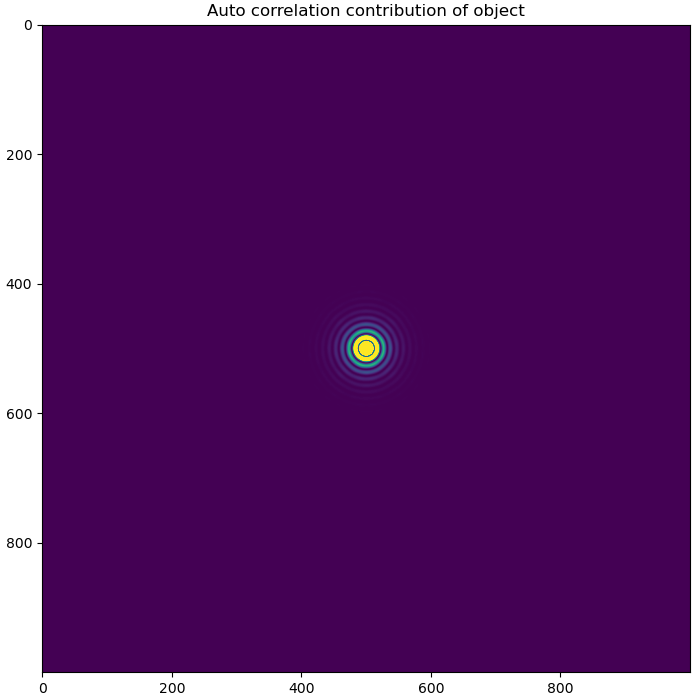

In [115]:
# Series of slideshow plots
fig, ax = cimshow(np.log10(holo_auto_reco+1))
ax.set_title("Auto correlation contribution of object")

interactive(children=(FloatRangeSlider(value=(9.467378432331972e-10, 0.0003577844875877148), description='cont…

interactive(children=(IntSlider(value=0, description='nr', max=1), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'Auto correlation contribution of references')

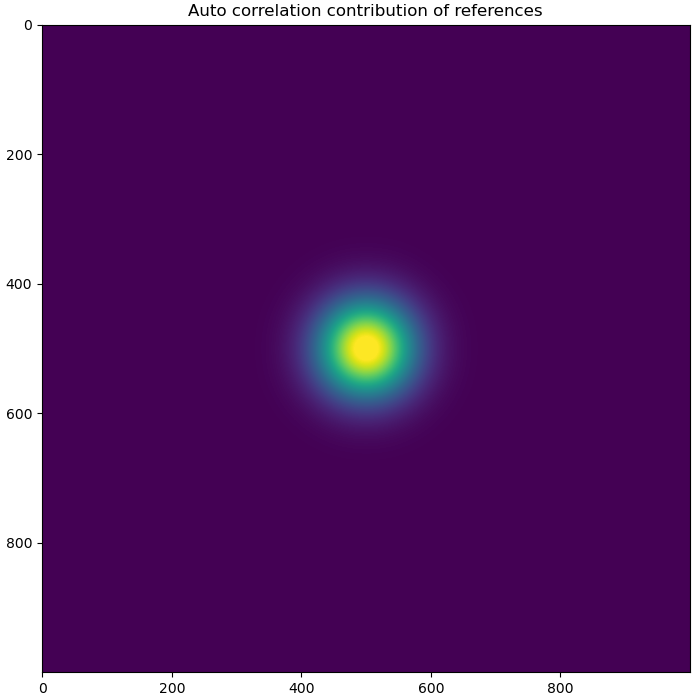

In [116]:
# Series of slideshow plots
fig, ax = cimshow(np.log10(holo_auto_ref+1))
ax.set_title("Auto correlation contribution of references")

# Calc time-averaged momentum space spectrum

interactive(children=(FloatRangeSlider(value=(-7.779637209179773, 5.563201131394959), description='contrast', …

(<Figure size 700x700 with 1 Axes>, <Axes: >)

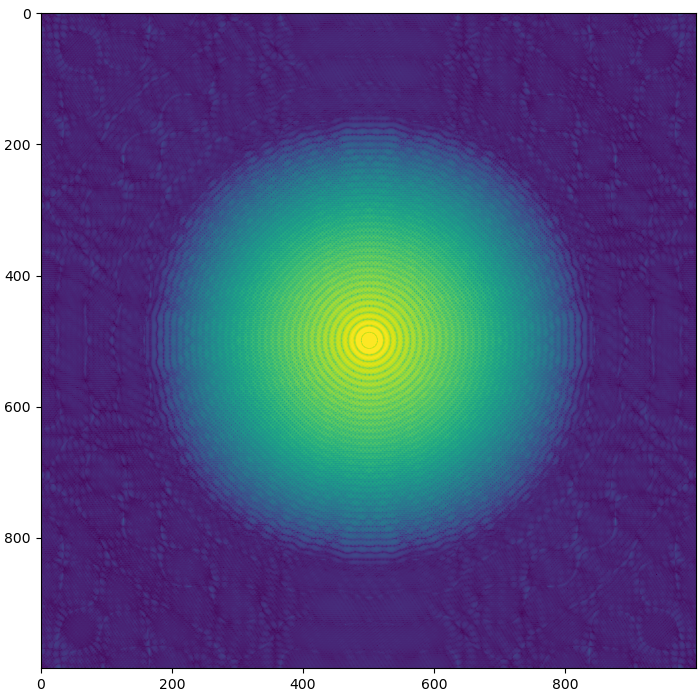

In [117]:
# Subtract all different contributions from the averaged hologram
fluctuation_spectrum = holo_avg - holo_auto_reco - np.sum(holo_auto_ref,axis=0) - np.sum(holo_cross_reco,axis=0) - np.sum(holo_cross_ref,axis=0)

# Plotting
cimshow(np.log10(fluctuation_spectrum))

# Normal phase retrieval

In [118]:
# Dummy Dict with most basic experimental parameter
experimental_setup = {
    "ccd_dist": 0.125,  # ccd to sample distance
    "px_size": 15e-6,  # pixel_size of camera
    "binning": 1,  # Camera binning
}

# Setup for azimuthal integrator
experimental_setup["energy"] = 778
experimental_setup["lambda"] = cci.photon_energy_wavelength(
    experimental_setup["energy"], input_unit="eV"
)

## Create normal support mask

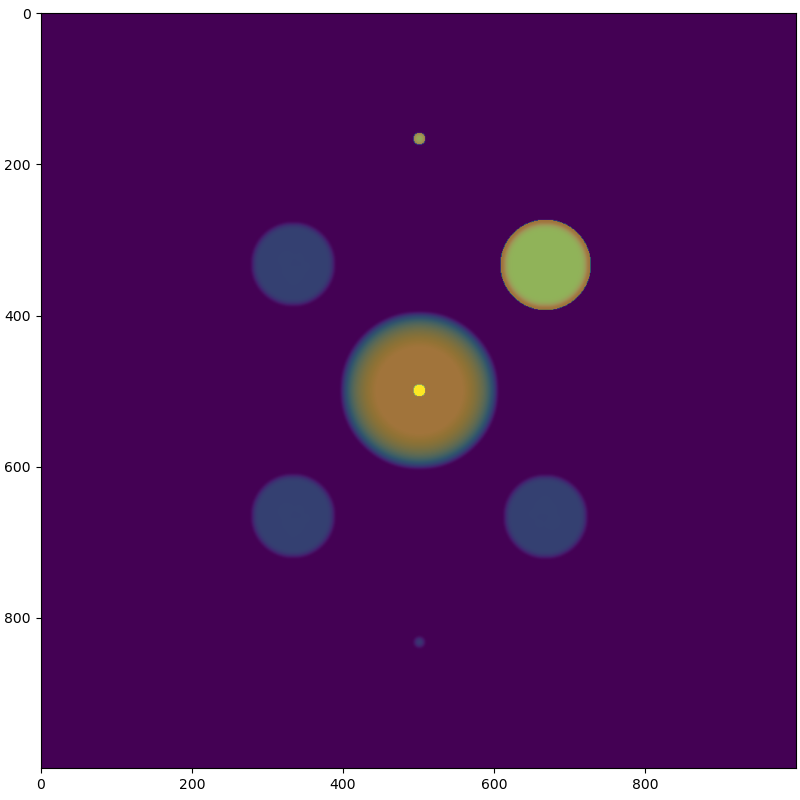

In [119]:
radi_ref_support = 8
radi_obj_support = 60

# Create support mask for phase retrieval of fluctuation part
supportmask = np.zeros(mask.shape)

# Object aperture
#rr, cc = disk((obj.shape[0]//3, obj.shape[1]//3), radi_obj+2, shape=obj.shape)
rr, cc = disk((obj.shape[0]//3+1, 2*obj.shape[1]//3+1), radi_obj_support, shape=obj.shape)
supportmask[rr,cc] = 1

# reference apertures
rr, cc = disk((0.5*obj.shape[0]//3+1, obj.shape[1]//2), radi_ref_support, shape=obj.shape)
supportmask[rr,cc] = 1
rr, cc = disk((obj.shape[0]//2, obj.shape[1]//2), radi_ref_support, shape=obj.shape)
supportmask[rr,cc] = 1

# Plotting
tmp = np.log10(np.abs(reco_avg)+1)
fig, ax = plt.subplots(figsize=(8,8))
vmin, vmax = np.percentile(tmp[tmp!=0],[5,99])
ax.imshow(tmp, vmin=vmin, vmax=vmax)
ax.imshow(supportmask,alpha = 0.5) 

In [120]:
roi_cdi = interactive.axis_to_roi(ax)
#roi_cdi = [138, 524, 477, 734]
roi_cdi = [270, 396, 603, 730]
roi_cdi = np.s_[roi_cdi[0] : roi_cdi[1], roi_cdi[2] : roi_cdi[3]]
print("Sliced roi:", roi_cdi)

Sliced roi: (slice(270, 396, None), slice(603, 730, None))


## Execute phase retrieval

In [121]:
(
    retrieved,
    _,
    bsmask,
    _,
) = phase_retrieval(holo_avg, np.zeros(mask.shape), supportmask, vmin = 0, Startimage=None, Startgamma=None)

CDI - larger mask
############ -   CDI
--- 0.54 seconds ---
############   -   CDI_pc
--- 2.56 seconds ---
Phase Retrieval Done!


Fine-tuning of reconstruction parameter:


interactive(children=(FloatSlider(value=0.0, description='propagation[um]', layout=Layout(width='90%'), max=10…

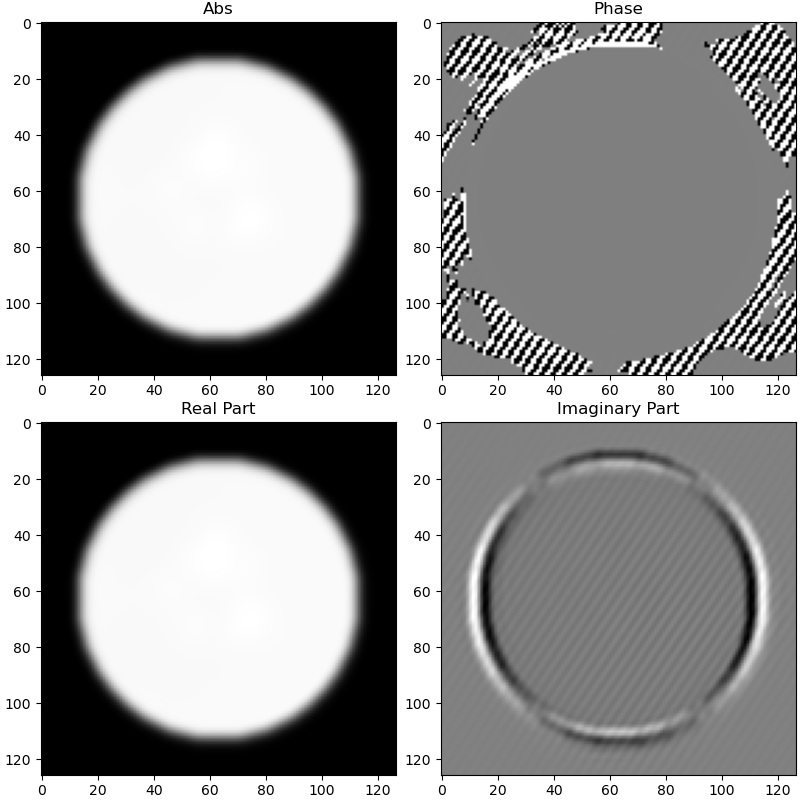

In [122]:
# New beamstop for CDI recos as phase retrieval of low-q might be insufficient. If phase retrieval worked well
# Try without beamstop: `use_bs = False`
use_bs = False
bs_diam_cdi = 32  # diameter of beamstop

# Create beamstop
if use_bs is True:
    mask_bs_cdi = 1 - mask_lib.circle_mask(
        mask.shape, np.array(mask.shape) / 2, bs_diam_cdi, sigma=4
    )
    mask_bs_cdi = 1 - mask_pixel_smooth.copy()
elif use_bs is False:
    mask_bs_cdi = np.ones(mask.shape)  # if you don't want a beamstop


# Get Reco
p = fth.reconstructCDI(
    fth.propagate(
        retrieved * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# Get Reco partial coherence
p_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# optimize phase
#_, phase_cdi = optimize_phase_contrast(p_pc, supportmask, method="contrast")

# Plotting
mode = "-"
print("Fine-tuning of reconstruction parameter:")
slider_prop, slider_phase, slider_dx, slider_dy = rec.focusCDI(
    retrieved * mask_bs_cdi,
    np.zeros(mask.shape),
    roi_cdi,
    mask=supportmask,
    phase=phase_cdi,
    dx=dx,
    dy=dy,
    prop_dist=prop_dist_cdi,
    experimental_setup=experimental_setup,
    operation=mode,
    max_prop_dist=10,
    scale=(0.1, 99.9),
)

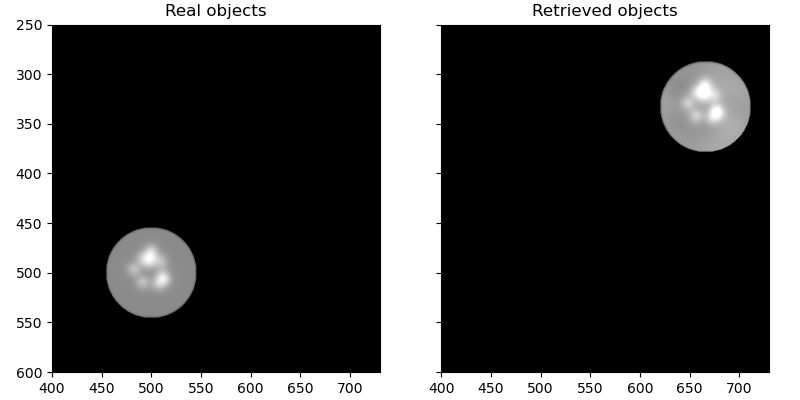

In [123]:
# Comparison of retrieved and real object
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
vmin, vmax = np.percentile(obj_all[obj_all>1-amplitude_object],[5,99.9])
ax[0].imshow(obj_all, vmin=vmin, vmax=vmax,cmap="gray")
ax[0].set_title("Real objects")
tmp = np.abs(p)*supportmask
vmin, vmax = np.percentile(tmp[tmp>500000],[15,98])
ax[1].imshow(tmp, vmin=vmin, vmax=vmax,cmap="gray")
ax[1].set_title("Retrieved objects")
ax[1].set_xlim([400,730])
ax[0].set_ylim([250,600])
ax[1].invert_yaxis()

# CIDI phase retrieval

## Create CIDI support mask

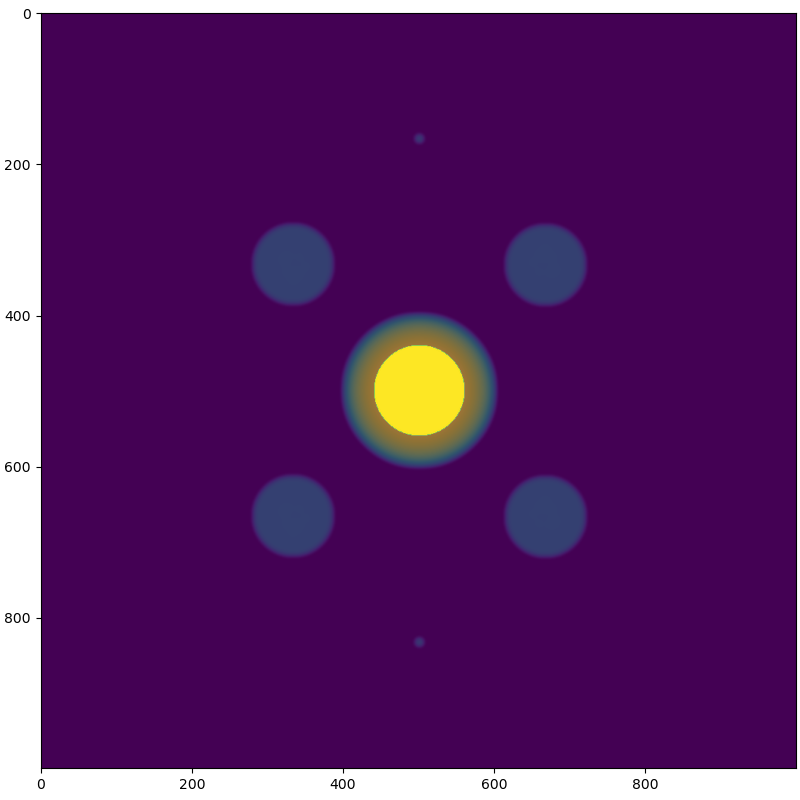

In [124]:
# Create support mask for phase retrieval of fluctuation part
supportmask = np.zeros(mask.shape)

# Object aperture
#rr, cc = disk((obj.shape[0]//3, obj.shape[1]//3), radi_obj+2, shape=obj.shape)
rr, cc = disk((obj.shape[0]//2, obj.shape[1]//2), radi_obj_support, shape=obj.shape)
supportmask[rr,cc] = 1

# Plotting
tmp = np.log10(np.abs(reco_avg)+1)
fig, ax = plt.subplots(figsize=(8,8))
vmin, vmax = np.percentile(tmp[tmp!=0],[5,99])
ax.imshow(tmp, vmin=vmin, vmax=vmax)
ax.imshow(supportmask,alpha = 0.5) 

In [125]:
roi_cdi = interactive.axis_to_roi(ax)
roi_cdi = [403, 597, 390, 617]
roi_cdi = np.s_[roi_cdi[0] : roi_cdi[1], roi_cdi[2] : roi_cdi[3]]
print("Sliced roi:", roi_cdi)

Sliced roi: (slice(403, 597, None), slice(390, 617, None))


## Execute phase retrieval

In [126]:
(
    retrieved,
    _,
    bsmask,
    _,
) = phase_retrieval(np.abs(fluctuation_spectrum), np.zeros(mask.shape), supportmask, vmin = 0, Startimage=None, Startgamma=None)

CDI - larger mask
############ -   CDI
--- 0.48 seconds ---
############   -   CDI_pc
--- 2.5 seconds ---
Phase Retrieval Done!


Fine-tuning of reconstruction parameter:


interactive(children=(FloatSlider(value=0.0, description='propagation[um]', layout=Layout(width='90%'), max=10…

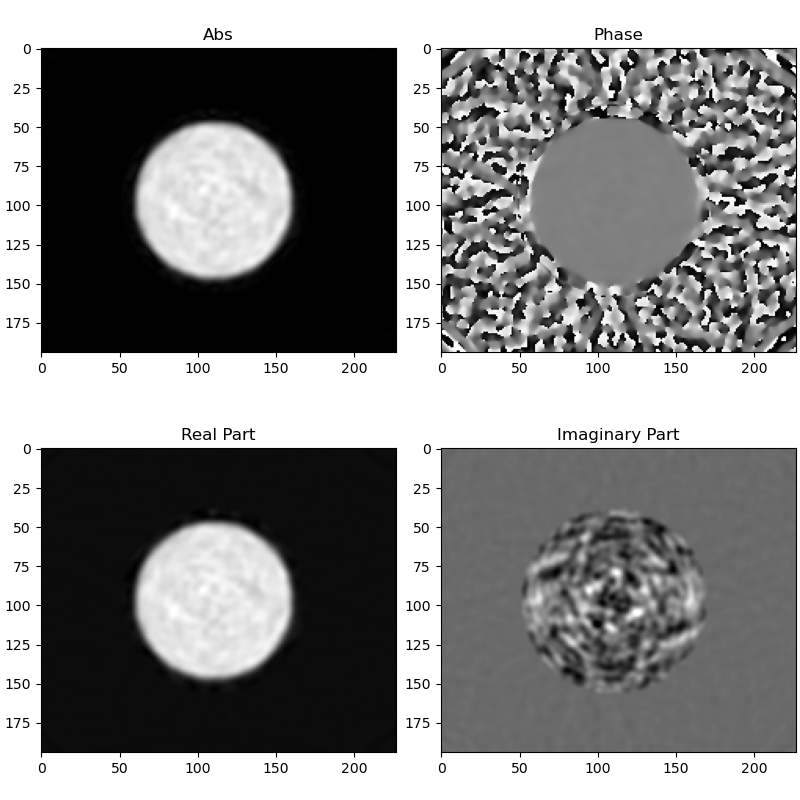

In [127]:
# New beamstop for CDI recos as phase retrieval of low-q might be insufficient. If phase retrieval worked well
# Try without beamstop: `use_bs = False`
use_bs = False
bs_diam_cdi = 32  # diameter of beamstop

# Create beamstop
if use_bs is True:
    mask_bs_cdi = 1 - mask_lib.circle_mask(
        mask.shape, np.array(mask.shape) / 2, bs_diam_cdi, sigma=4
    )
    mask_bs_cdi = 1 - mask_pixel_smooth.copy()
elif use_bs is False:
    mask_bs_cdi = np.ones(mask.shape)  # if you don't want a beamstop


# Get Reco
p = fth.reconstructCDI(
    fth.propagate(
        retrieved * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# Get Reco partial coherence
p_pc = fth.reconstructCDI(
    fth.propagate(
        retrieved * mask_bs_cdi,
        prop_dist_cdi * 1e-6,
        experimental_setup=experimental_setup,
    )
)

# optimize phase
#_, phase_cdi = optimize_phase_contrast(p_pc, supportmask, method="contrast")

# Plotting
mode = "-"
print("Fine-tuning of reconstruction parameter:")
slider_prop, slider_phase, slider_dx, slider_dy = rec.focusCDI(
    retrieved * mask_bs_cdi,
    np.zeros(mask.shape),
    roi_cdi,
    mask=supportmask,
    phase=phase_cdi,
    dx=dx,
    dy=dy,
    prop_dist=prop_dist_cdi,
    experimental_setup=experimental_setup,
    operation=mode,
    max_prop_dist=10,
    scale=(0.1, 99.9),
)

Text(0.5, 1.0, 'CIDI object')

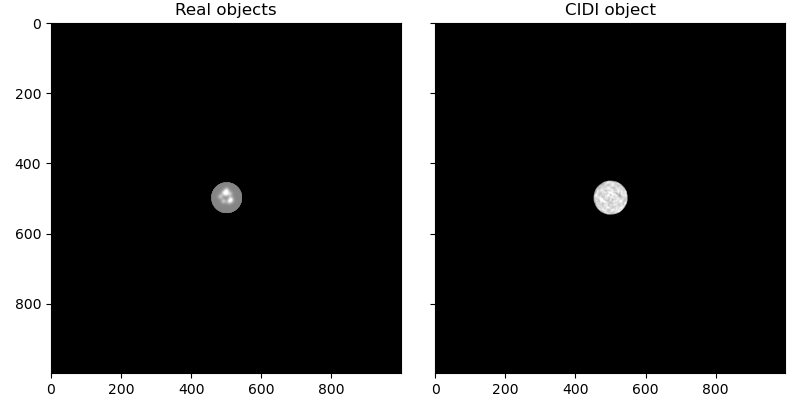

In [128]:
# Comparison of retrieved and real object
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
vmin, vmax = np.percentile(obj_all[obj_all!=0],[10,99])
ax[0].imshow(obj_all, vmin=1-amplitude_object+.08, vmax=vmax,cmap="gray")
ax[0].set_title("Real objects")
tmp = np.abs(p)*supportmask
vmin, vmax = np.percentile(tmp[tmp>2000],[1,99])
ax[1].imshow(tmp, vmin=5e5, vmax=vmax,cmap="gray")
ax[1].set_title("CIDI object")